## Differential abundance analysis with Milopy

Following this tutorial:
https://milopy.readthedocs.io/en/latest/milopy_example.html

In [1]:
# basic python packages
import numpy as np
import pandas as pd
import os
import sys 

# plotting
from matplotlib import pyplot as plt 
import seaborn as sns 
import scipy.stats as stats

# singlecell packages
import scanpy as sc
import anndata
import memento
import milopy.core as milo 
import milopy.plot as milopl

#sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')

In [35]:
# set the project directory 
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/clustering/Tcells')
data_dir = 'data/'
fig_dir = 'figures/'

In [71]:
# re-load the final dataset
cur_celltype = 'Tcells'
adata = sc.read_h5ad('{}/{}_integrated.h5ad'.format(data_dir, cur_celltype))

## Follow the milopy tutorial 


In [73]:
adata_full = adata.copy()

# subset Lung Mets at the initial timepoint
adata = adata_full[
    (adata_full.obs.Tissue == 'Liver met') & 
    (adata_full.obs.Timepoint == 1) &
    (adata_full.obs.dataset == 'SERPENTINE')
].copy()

In [74]:
adata.obs.Tissue.value_counts()

Tissue
Liver met    41899
Name: count, dtype: int64

In [75]:
sc.pp.neighbors(
    adata,
    n_neighbors=50, n_pcs=20,
    use_rep = 'X_pca_CellANOVA'
)

### Pt1. Construct neighborhoods

In [76]:
? milo.make_nhoods

Signature:
 milo.make_nhoods(
    adata: anndata._core.anndata.AnnData,
    neighbors_key: str = None,
    prop=0.1,
    seed: int = 42,
)
Docstring:
This function randomly samples vertcies on a graph to define neighbourhoods.
These are then refined by computing the median profile for the neighbourhood
in reduced dimensional space and selecting the nearest vertex to this
position. Thus, multiple neighbourhoods may be collapsed down together to
prevent over-sampling the graph space.

- adata: AnnData object. Should contain a knn graph in `adata.obsp`
- neighbors_key: string indicating the key in `adata.obsp` to use as KNN graph. If not specified, 
`make_nhoods` looks .obsp[‘connectivities’] for connectivities (default storage places for
`scanpy.pp.neighbors`). If specified, it looks .obsp[.uns[neighbors_key][‘connectivities_key’]] for
connectivities.
- prop: fraction of cells to sample for neighbourhood index search (default: 0.1)
- seed: random seed for cell sampling (default: 42)
File

In [77]:
milo.make_nhoods(adata, prop=0.1)

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/milopy/core.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.54655218 4.2057333  4.2962594  ... 5.52186155 5.39439964 5.00112391]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"]


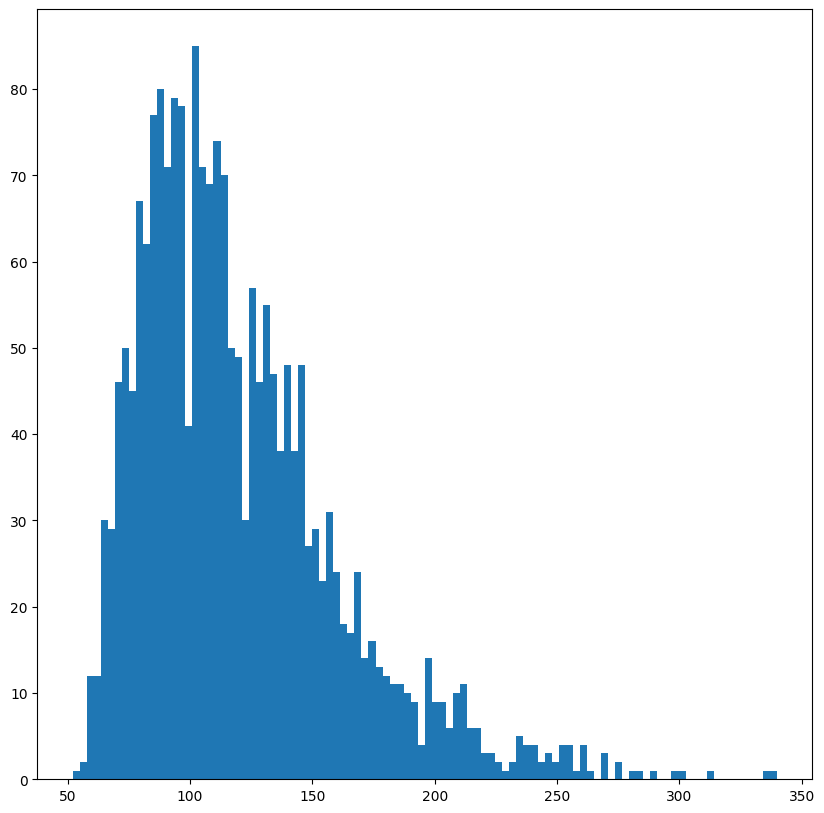

In [78]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [79]:
# count cells in neighborhoods:
milo.count_nhoods(adata, sample_col="Replicate")

## Differential abundance testing

In [80]:
milo.DA_nhoods(adata, design="~Microsatellite_status")

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/milopy/core.py:239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if design_df.dtypes[i].name == 'category':
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/milopy/core.py:311: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/milopy/core.py:312: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

In [81]:
adata.uns["nhood_adata"].obs


,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,GTGCATATCATCGGAT-1-0-1,4.546552,0.178828,9.852251,0.031039,0.860155,0.963013,0.968003
1,GGACATTCAGCTCGCA-1-0-1,4.205733,1.898771,10.845234,2.511470,0.113036,0.483401,0.483351
2,GGGTCTGCAGCTCGAC-1-0-1,4.296259,1.951191,10.110334,2.731571,0.098398,0.447634,0.446713
3,GTAGGCCGTACAGTGG-1-0-1,4.206119,0.763252,10.881178,0.494144,0.482092,0.834429,0.843619
4,GTGCTTCCAGAGTGTG-1-0-1,5.225926,-0.328216,9.866495,0.110861,0.739170,0.917556,0.922894
...,...,...,...,...,...,...,...,...
2074,CCGGTAGGTGCGGTAA-1-43-1,6.843729,-0.248165,9.685470,0.061386,0.804321,0.938373,0.942618
2075,CCGTACTGTCGGGTCT-1-43-1,4.480867,-2.184288,10.313745,6.163438,0.013050,0.230870,0.224906
2076,CCCAGTTGTTCGGGCT-1-43-1,5.521862,-2.578316,9.196708,6.190415,0.012852,0.230870,0.224906
2077,CCCATACGTGCGGTAA-1-43-1,5.394400,-1.704189,9.568861,3.434311,0.063869,0.368277,0.366123


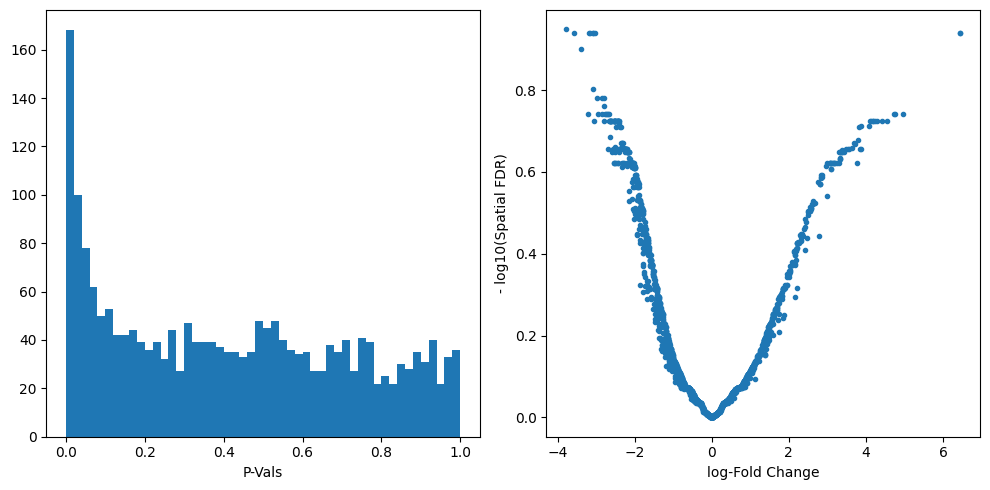

In [82]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

## Visualize on embedding

In [83]:
import milopy.utils
milopy.utils.build_nhood_graph(adata)

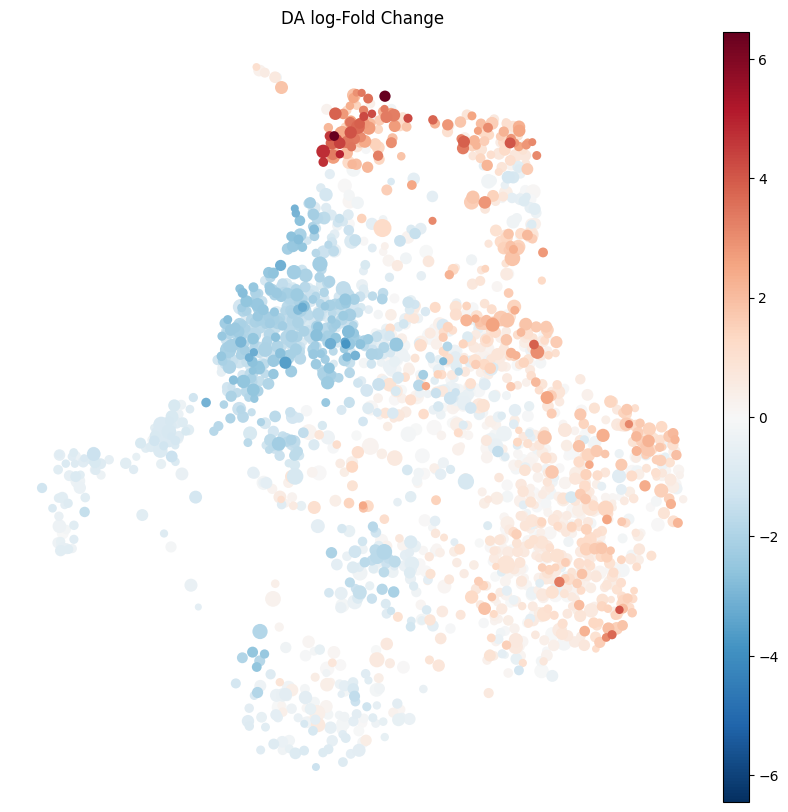

In [84]:
plt.rcParams["figure.figsize"] = [10,10]
milopl.plot_nhood_graph(adata, 
                        alpha=1, ## SpatialFDR level (1%) 
                        min_size=2 ## Size of smallest dot
                       )

## Visualize by cell type

In [85]:
milopy.utils.annotate_nhoods(adata, anno_col='leiden_1')

In [86]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6,"leiden_1"] = "Mixed"


In [87]:
adata.uns['nhood_adata'].obs["nhood_annotation_frac"]

0       0.582609
1       0.861111
2       0.887218
3       0.930894
4       0.663793
          ...   
2074    0.989691
2075    0.891192
2076    0.684932
2077    0.585859
2078    0.886364
Name: nhood_annotation_frac, Length: 2079, dtype: float32

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


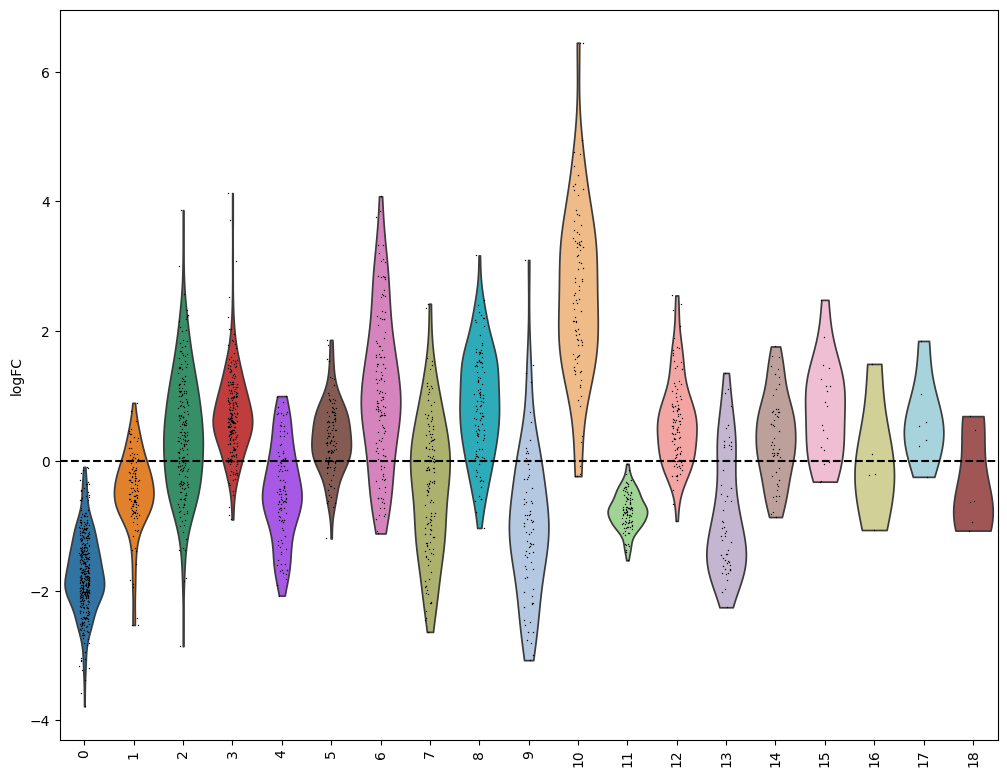

In [88]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

In [89]:
adata.obs.columns

Index(['Replicate', 'Patient', 'Age', 'Tumor_Type', 'Molecular_profile',
       'Treatment', 'Response', 'Tissue', 'Timepoint', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden',
       'cell_type', 'dataset', 'Sex', 'orig_annotation', 'batch', 'leiden_1',
       'leiden_2', 'leiden_3', 'Microsatellite_status', 'doublet_score',
       'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'],
      dtype='object')

In [90]:
adata.obs.leiden_3.value_counts()

leiden_3
3     3239
5     2526
10    2241
2     2147
7     1904
13    1851
0     1731
12    1573
21    1517
8     1497
20    1439
23    1369
6     1339
17    1321
4     1284
11    1262
15    1163
14    1133
26    1118
19    1080
22     984
25     937
1      875
24     838
16     774
9      765
29     685
27     601
18     580
30     461
31     360
32     269
28     261
35     204
34     150
40      93
33      91
38      83
39      72
37      55
36      27
Name: count, dtype: int64